<a href="https://colab.research.google.com/github/slowvak/AI-Deep-Learning-Lab/blob/master/BasicPyTorchNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

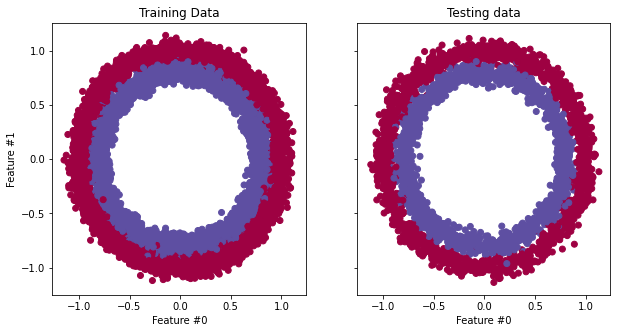

In [17]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

# Create a dataset with 10,000 samples.
SAMPLES = 10000
TEST_FRAC = 0.33
X, y = make_circles(n_samples = SAMPLES,
                    noise= 0.05,
                    random_state=26)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_FRAC, random_state=26)

# Visualize the data--our goal is to train a network to make a circle
fig, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 5))
train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Spectral)
train_ax.set_title("Training Data")
train_ax.set_xlabel("Feature #0")
train_ax.set_ylabel("Feature #1")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Spectral)
test_ax.set_xlabel("Feature #0")
test_ax.set_title("Testing data")
plt.show()


Now we need to convert the data from numpy to torch format

In [18]:
import warnings
warnings.filterwarnings("ignore")

!pip install torch -q

import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader

# Convert data to torch tensors
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len
   
batch_size = 64

# Instantiate training and test data
train_data = Data(X_train, y_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = Data(X_test, y_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

# Check it's working
for batch, (X, y) in enumerate(train_dataloader):
    print(f"Batch: {batch+1}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    break


"""
Batch: 1
X shape: torch.Size([64, 2])
y shape: torch.Size([64])
"""


Batch: 1
X shape: torch.Size([64, 2])
y shape: torch.Size([64])


'\nBatch: 1\nX shape: torch.Size([64, 2])\ny shape: torch.Size([64])\n'

Now we build the network. It will have just 2 layers. We will start with the ReLU activation function. 

In [19]:

import torch
from torch import nn
from torch import optim

input_dim = 2
hidden_dim = 10
output_dim = 1

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        # here we initilize the network
        nn.init.kaiming_uniform_(self.layer_1.weight, nonlinearity="relu")
        # normal distribution
#        nn.init.uniform_(self.layer_1.weight, a=0.0, b=1.0)
        # this will intialize the weights and biases as 0's
#        nn.init.zeros_(self.layer_1.weight)
        # this is the Xavier or Glorot init
#        nn.init.xavier_uniform_(self.layer_1.weight, gain=1.0)

        self.layer_2 = nn.Linear(hidden_dim, output_dim)
       
    def forward(self, x):
        # this is the hidden layer, including activation function
        x = torch.nn.functional.relu(self.layer_1(x))
#        x = torch.nn.functional.leaky_relu(self.layer_1(x))
#        x = torch.nn.functional.elu(self.layer_1(x))
#        x = torch.nn.functional.gelu(self.layer_1(x))

        # this is the output loayer
        x = torch.nn.functional.sigmoid(self.layer_2(x))

        return x
       
model = NeuralNetwork(input_dim, hidden_dim, output_dim)
#print(model)



Note in the 'forward' function, the firest layer has the relu activation function. But the second layer uses sigmoid. Why?

Now we are ready to train it. 

Training Complete


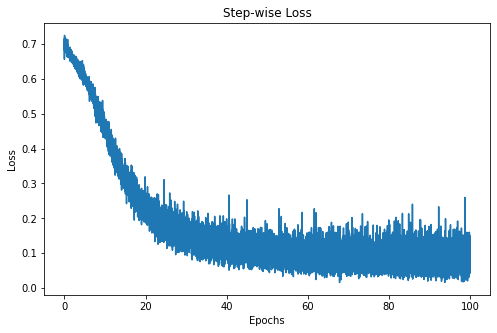

In [20]:

learning_rate = 0.1
model = NeuralNetwork(input_dim, hidden_dim, output_dim)
loss_fn = nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

num_epochs = 100
loss_values = []


for epoch in range(num_epochs):
    for X, y in train_dataloader:
        # zero the parameter gradients
        optimizer.zero_grad()  
       
        # forward prediction
        pred = model(X)
        # calc the errors
        loss = loss_fn(pred, y.unsqueeze(-1))
        loss_values.append(loss.item())
        # backward 
        loss.backward()
        # update the weights based on gradients using optimizer
        optimizer.step()

print("Training Complete")

"""
Training Complete
"""

step = np.linspace(0, 100, 105*num_epochs)

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(loss_values))
plt.title("Step-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()      

Lets see how it trained...

That looks promising, but a loss curve isn't do the real-world work, so lets make it work. We use the term 'inference' to have a trained network make a prediction on new/unseen data

In [21]:

import itertools

y_pred = []
y_test = []
total = 0
correct = 0

with torch.no_grad():
    for X, y in test_dataloader:
        outputs = model(X)
        predicted = np.where(outputs < 0.5, 0, 1)
        predicted = list(itertools.chain(*predicted))
        y_pred.append(predicted)
        y_test.append(y)
        total += y.size(0)
        correct += (predicted == y.numpy()).sum().item()

print(f'Accuracy of the network on the {SAMPLES * TEST_FRAC} test instances: {100 * correct // total}%')



Accuracy of the network on the 3300.0 test instances: 97%


              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98      1635
         1.0       0.97      0.98      0.98      1665

    accuracy                           0.98      3300
   macro avg       0.98      0.98      0.98      3300
weighted avg       0.98      0.98      0.98      3300



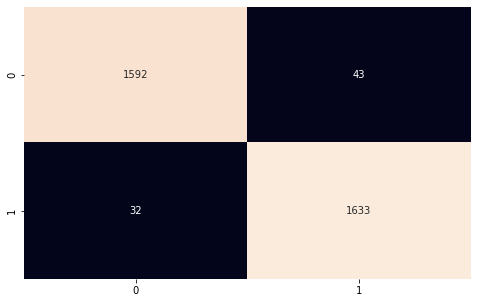

In [22]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = list(itertools.chain(*y_pred))
y_test = list(itertools.chain(*y_test))

print(classification_report(y_test, y_pred))


cf_matrix = confusion_matrix(y_test, y_pred)

plt.subplots(figsize=(8, 5))

sns.heatmap(cf_matrix, annot=True, cbar=False, fmt="g")

plt.show()


# Results by activation function
| Function | 10 epochs ACC | 100 epochs | 1000 epochs | 100 epochs Kaiming |
|----------|----------------|-----------|-------------|--------------------|
| ReLU | 88 | 98 | 97 | 97 |
| leaky RELU | 89 | 97 | 98 | 98 |
| ELU | 57 | 95 | 97 | 98 |
| GELU | 82 | 97 | 97 | 98 |
